### 1. Подготовьте данные для word2vec по одной из недавно прочитанных и обучите модель

In [1]:
import codecs
import numpy as np
import gensim
from gensim.models import Word2Vec

# загрузка файла
with codecs.open('persi.txt', mode='r') as file:
    docs = file.readlines()
    
max_sen_len = 12

# предварительная обработка
sentences = [sent for doc in docs for sent in doc.split('.')]
sentences = [[word for word in sent.lower().split()[:max_sen_len]] for sent in sentences]
print('Всего', len(sentences),'предложений')

Всего 14555 предложений


In [2]:
# обучение
model = gensim.models.Word2Vec(sentences, vector_size=100, min_count=1, window=5, epochs=100)

pretrained_weights = model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Размер словаря:', vocab_size)
print('Размер каждого вектора:', emdedding_size)

Размер словаря: 17208
Размер каждого вектора: 100


In [64]:
sim_words = model.wv.most_similar('человек') 
for words in sim_words:
    print(words)

('приземистый', 0.7361227869987488)
('леопардовой', 0.6976988315582275)
('молодой', 0.6477242708206177)
('обыкновенный', 0.6444881558418274)
('гавайской', 0.6417467594146729)
('шум', 0.6335494518280029)
('гарлеме', 0.6268101334571838)
('черном?', 0.6119715571403503)
('школьного', 0.6084041595458984)
('отеделение?', 0.5855964422225952)


In [3]:
sim_words = model.wv.most_similar('пророчество') 
for words in sim_words:
    print(words)

('предупреждает', 0.7625859975814819)
('ребенке,', 0.6998143792152405)
('которому', 0.6756278872489929)
('привело', 0.6692213416099548)
('долгожданное', 0.660474419593811)
('раскрывается', 0.6487653255462646)
('видении,которое', 0.6444886326789856)
('думал', 0.6348645091056824)
('джодж', 0.6334055662155151)
('живым,', 0.6330338716506958)


In [4]:
sim_words = model.wv.most_similar('герой') 
for words in sim_words:
    print(words)

('великий', 0.6497102379798889)
('пророчества?', 0.607123851776123)
('осуждающе', 0.5921017527580261)
('орфей', 0.5902287364006042)
('оуэн', 0.5865791440010071)
('kool-aid,', 0.5812691450119019)
('готов,', 0.5771592259407043)
('награду,', 0.5759702920913696)
('нюхать', 0.5524123311042786)
('вечеринка,', 0.5503742694854736)


In [69]:
sim_words = model.wv.most_similar('олимп') 
for words in sim_words:
    print(words)

('грани', 0.6018781661987305)
('детонатора,', 0.5897119641304016)
('кнопку', 0.5869900584220886)
('падения,', 0.5855629444122314)
('падет,', 0.5796062350273132)
('пешеходов', 0.5691882967948914)
('дней,', 0.5627169013023376)
('перестроить', 0.5542925596237183)
('остался', 0.5461438894271851)
('фактически', 0.5447206497192383)


In [70]:
sim_words = model.wv.most_similar('кронос') 
for words in sim_words:
    print(words)

('он', 0.5472914576530457)
('здесь!"', 0.5343891978263855)
('лука', 0.5259333252906799)
('пандоры,', 0.5241441130638123)
('громче:', 0.5074095129966736)
('аид', 0.5010095238685608)
('воздушный', 0.49866342544555664)
('тайсон', 0.48851388692855835)
('гудзон', 0.4884437620639801)
('неправильно,', 0.4840896725654602)


In [71]:
vec = model.wv.most_similar(positive=['человек', 'бог'], negative=['бог'])
vec

[('приземистый', 0.7361227869987488),
 ('леопардовой', 0.697698712348938),
 ('молодой', 0.6477242708206177),
 ('обыкновенный', 0.6444880962371826),
 ('гавайской', 0.6417466998100281),
 ('шум', 0.6335494518280029),
 ('гарлеме', 0.6268100738525391),
 ('черном?', 0.6119715571403503),
 ('школьного', 0.6084041595458984),
 ('отеделение?', 0.5855963826179504)]

In [73]:
vec = model.wv.most_similar(positive=['бог', 'олимп'], negative=['аид'])
vec

[('грани', 0.5339633822441101),
 ('падения,', 0.5314422249794006),
 ('различным', 0.5209038853645325),
 ('дней,', 0.5137315988540649),
 ('путешественников', 0.50180584192276),
 ('пережил', 0.48928552865982056),
 ('каждый', 0.47728490829467773),
 ('принцессе', 0.4718187153339386),
 ('нормально,', 0.4694176912307739),
 ('разделиться,', 0.46187666058540344)]

### 2. Для обучения на нефтяных скважин добавьте во входные данные информацию со столбцов Gas, Water (т. е. размер x_data будет (440, 12, 3)) и обучите новую модель. Выход содержит Liquid, Gas (для дальнейшего предсказания). Графики с результатами для Liquid

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

df = pd.read_csv('production.csv')
df


,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,5005072170100,2014,11,9783,11470,1.172442,10558,1.079219,14,2016-04-06 17:20:05.757
1,5005072170100,2014,12,24206,26476,1.093778,5719,0.236264,31,2016-04-06 17:20:05.757
2,5005072170100,2015,1,20449,26381,1.290088,2196,0.107389,31,2016-04-06 17:20:05.757
3,5005072170100,2015,2,6820,10390,1.523460,583,0.085484,28,2016-04-06 17:20:05.757
4,5005072170100,2015,3,7349,7005,0.953191,122,0.016601,13,2016-06-16 14:07:33.203
...,...,...,...,...,...,...,...,...,...,...
1195,49021210550000,2015,10,1262,665,0.526941,341,0.270206,31,2016-04-06 15:40:34.957
1196,49021210550000,2015,11,1410,826,0.585816,572,0.405674,30,2016-04-06 15:40:34.957
1197,49021210550000,2015,12,1443,895,0.620236,620,0.429660,31,2016-04-06 15:40:34.957
1198,49021210550000,2016,1,1654,988,0.597340,808,0.488513,31,2016-04-06 15:40:34.957


In [4]:
# Подготовка данных по добыче

liquid = df.groupby('API')['Liquid'].apply(lambda df_: df_.reset_index(drop=True))
gas = df.groupby('API')['Gas'].apply(lambda df_: df_.reset_index(drop=True))
water = df.groupby('API')['Water'].apply(lambda df_: df_.reset_index(drop=True))


In [5]:
df_prod = gas.unstack()
df_prod2 = water.unstack()
df_prod3 = liquid.unstack()

In [8]:
# Масштабирование
# Gas
data = df_prod.values
data = data / data.max()
data = data[:, :, np.newaxis]
# Water
data2 = df_prod2.values
data2 = data2 / data2.max()
data2 = data2[:, :, np.newaxis]
# Liquid
data3 = df_prod3.values
data3 = data3 / data3.max()
data3 = data3[:, :, np.newaxis]



In [9]:
# Деление на трейн/тест (80 на 20)

data_tr_gas = data[:40]
data_tr_water = data2[:40]
data_tr_liquid = data3[:40]

data_tst_gas = data[40:]
data_tst_water = data2[40:]
data_tst_liquid = data3[40:]

# Объединяем
a = np.concatenate([data_tst_gas, data_tst_water], axis=2)
data_tst = np.concatenate([a, data_tst_liquid], axis=2)


In [13]:
x_data_liquid = [data_tr_liquid[:, i:i+12] for i in range(11)]
y_data_liquid = [data_tr_liquid[:, i+1:i+13] for i in range(11)]

x_data_water = [data_tr_water[:, i:i+12] for i in range(11)]
y_data_water = [data_tr_water[:, i+1:i+13] for i in range(11)]

x_data_gas = [data_tr_gas[:, i:i+12] for i in range(11)]
y_data_gas = [data_tr_gas[:, i+1:i+13] for i in range(11)]



x_data_liquid = np.concatenate(x_data_liquid, axis=0)
y_data_liquid = np.concatenate(y_data_liquid, axis=0)

x_data_water = np.concatenate(x_data_water, axis=0)
y_data_water = np.concatenate(y_data_water, axis=0)

x_data_gas = np.concatenate(x_data_gas, axis=0)
y_data_gas = np.concatenate(y_data_gas, axis=0)



arr = np.concatenate([x_data_liquid, x_data_water], axis=2)
x_data = np.concatenate([arr, x_data_gas], axis=2)

arr2 = np.concatenate([y_data_liquid, y_data_water], axis=2)
y_data = np.concatenate([arr2, y_data_gas], axis=2)


print(x_data.shape, y_data.shape)

(440, 12, 3) (440, 12, 3)


In [16]:
tensor_x = torch.Tensor(x_data) # transform to torch tensor
tensor_y = torch.Tensor(y_data)

oil_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
oil_dataloader = DataLoader(oil_dataset, batch_size=16) # create your dataloader

In [24]:
for x_t, y_t in oil_dataloader:
    break
x_t.shape, y_t.shape

(torch.Size([16, 12, 3]), torch.Size([16, 12, 3]))

In [25]:
class OilModel(nn.Module):
    def __init__(self, timesteps=12, units=32):
        super().__init__()
        self.lstm1 = nn.LSTM(3, units, 2, batch_first=True)
        self.dense = nn.Linear(units, 3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h, _ = self.lstm1(x)
        outs = []
        for i in range(h.shape[0]):
            outs.append(self.relu(self.dense(h[i])))
        out = torch.stack(outs, dim=0)
        return out

In [26]:
model = OilModel()
opt = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [27]:
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    num = 0
    for x_t, y_t in oil_dataloader:
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(x_t)
        loss = criterion(outputs, y_t)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.item()
        num += 1
        
    print(f'[Epoch: {epoch + 1:2d}] loss: {running_loss / num:.3f}')

print('Finished Training')

[Epoch:  1] loss: 0.013
[Epoch:  2] loss: 0.011
[Epoch:  3] loss: 0.011
[Epoch:  4] loss: 0.010
[Epoch:  5] loss: 0.009
[Epoch:  6] loss: 0.009
[Epoch:  7] loss: 0.009
[Epoch:  8] loss: 0.009
[Epoch:  9] loss: 0.008
[Epoch: 10] loss: 0.008
[Epoch: 11] loss: 0.008
[Epoch: 12] loss: 0.008
[Epoch: 13] loss: 0.008
[Epoch: 14] loss: 0.008
[Epoch: 15] loss: 0.008
[Epoch: 16] loss: 0.008
[Epoch: 17] loss: 0.008
[Epoch: 18] loss: 0.008
[Epoch: 19] loss: 0.008
[Epoch: 20] loss: 0.008
Finished Training


In [28]:
# Предскажем на год вперёд используя данные только первого года
x_tst = data_tst[:, :12]
predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))

for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    x_t = torch.from_numpy(x).float()
    pred = model(x_t).detach().numpy()
    last_pred = pred[:, -1:]  # Нас интересует только последний месяц
    predicts = np.concatenate((predicts, last_pred), axis=1)
    

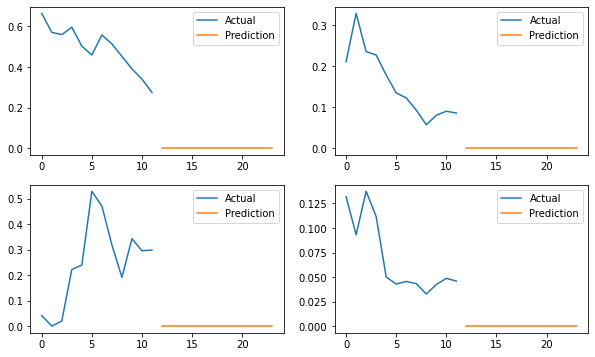

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for iapi in range(4):
    plt.subplot(2, 2, iapi+1)
    plt.plot(np.arange(x_tst.shape[1]), x_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts.shape[1])+x_tst.shape[1], predicts[iapi, :, 0], label='Prediction')
    plt.legend()
plt.show()

### 3. Из этого же текста (п.1) возьмите небольшой фрагмент, разбейте на предложения с одинаковым числом символов. Каждый символ предложения закодируйте с помощью one hot encoding. В итоге у вас должен получиться массив размера (n_sentences, sentence_len, encoding_size).

In [3]:
import re

with open('persi_.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    text = re.sub(r'[^А-я ]', '', text) #  оставим в тексте только символы русских букв и символы пробела

text = text.lower() # переводим в нижний регистр

text

'весь год полубоги готовились к сражению против титанов зная что шансы на победу очень малы армия кроноса сильна как никогда и с каждым богом и полукровкой которого он вербует власть злого титана только растет в то время как олимпийцы изо всех сил пытаются сдержать неистовствующего монстра тифона кронос начинает продвижение на ньюйорк где находится абсолютно неохраняемая гора олимп теперь это дело перси джексона и армии молодых полубогов остановить бога времени в этой важной заключительной книге раскрывается долгожданное пророчество о шестнадцатом дне рождения перси и так как сражение за западную цивилизацию бушует на улицах манхэттана перси оказывается перед ужасающим подозрением что он может бороться против своей собственной судьбы'

In [17]:
CHARS  = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя "        # алфавит + пробел

#  отображение символов в целые числа
char_to_int = dict((c, i) for i, c in enumerate(CHARS)) 
int_to_char = dict((i, c) for i, c in enumerate(CHARS)) 
# входные данные кодируются в целых числах 
int_encoded = [char_to_int[char] for char in text] 

n = 12 # количество символов в одном предложении

chunks = [int_encoded[i:i+n] for i in range(0, len(int_encoded), n)] 

print('Всего', len(chunks),'предложений')


Всего 62 предложений


In [6]:
# one hot encode 
import numpy as np
onehot_encoded = list() 
for value in int_encoded: 
  letter = [0 for _ in range(len(CHARS))] 
  letter[value] = 1 
  onehot_encoded.append(letter) 
onehot_encoded= np.array(onehot_encoded)
onehot_encoded.resize(62, 12, 34)
# по условию массив должен быть размером (n_sentences, sentence_len, encoding_size)
# в данном случае 62 предложения, количество символов в каждом - 12, размер кодировки - 34 (33 буквы алфавита и пробел)
print('Размерность массива:', onehot_encoded.shape)
onehot_encoded


Размерность массива: (62, 12, 34)


array([[[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 

In [7]:
print(onehot_encoded[0][0])

#например, в тексте первая буква 'в', по порядку в алфовите третья
#но т.к. индексация с нуля, то 'в' = '2' -> поэтому отмечен 2-ой индекс как 1 для 'в'

#вторая буква 'е' - шестая по алфавиту, по индексу - пятая -> поэтому отмечен 5-ой индекс как 1 для ''
#с другими символами аналогично

print(onehot_encoded[0][1])

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### 4. На полученных в п.3 задании обучение модель RNN для предсказания следующего символа. Посмотрите результат при последовательной генерации.

In [15]:

import tensorflow as tf
from tensorflow.keras import layers
recurrent_model = tf.keras.Sequential()
recurrent_model.add(tf.keras.Input((12, 34))) #при тренировке в рекуррентные модели keras подается сразу вся последовательность, поэтому в input теперь два числа. 1-длина последовательности, 2-размер OHE
recurrent_model.add(tf.keras.layers.SimpleRNN(500)) #рекуррентный слой на 500 нейронов
recurrent_model.add(tf.keras.layers.Dense(34, activation='softmax'))
recurrent_model.summary()

onehot_encoded.resize(744, 34)
n = onehot_encoded.shape[0]-12
X = np.array([onehot_encoded[i:i+12, :] for i in range(n)])
Y = onehot_encoded[12:] 

recurrent_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = recurrent_model.fit(X, Y, batch_size=32, epochs=200)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 500)               267500    
                                                                 
 dense_8 (Dense)             (None, 34)                17034     
                                                                 
Total params: 284,534
Trainable params: 284,534
Non-trainable params: 0
_________________________________________________________________
(732, 12, 34)
(732, 34)
Epoch 1/200
23/23 [==============================] - 3s 36ms/step - loss: 3.2676 - accuracy: 0.1038
Epoch 2/200
23/23 [==============================] - 1s 31ms/step - loss: 2.6557 - accuracy: 0.2514
Epoch 3/200
23/23 [==============================] - 1s 29ms/step - loss: 2.3420 - accuracy: 0.3060
Epoch 4/200
23/23 [==============================] - 1s 30ms/step - loss: 2.0846 - accuracy: 0.3880
Epoch 5/200
23/23 [=

In [19]:
'''def buildPhrase(inp_str, str_len = 50):
  for i in range(str_len):
    x = []
    for j in range(i, i+12):
      x.append(tokenizer.texts_to_matrix(inp_str[j])) # преобразуем символы в One-Hot-encoding
 
    x = np.array(x)
    inp = x.reshape(1, inp_chars, num_characters)
 
    pred = model.predict( inp ) 
    d = tokenizer.index_word[pred.argmax(axis=1)[0]] # получаем ответ в символьном представлении
 
    inp_str += d # дописываем строку
 
  return inp_str
  
  '''

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x000001EEB00E7A30>>